In [129]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch import Tensor
import torch
from sklearn.decomposition import PCA
import heapq
from sklearn.svm import SVC
from sklearn.model_selection import GroupShuffleSplit
import seaborn as sns
from itertools import zip_longest
from scipy.stats import ttest_ind
import statistics

In [3]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [4]:
import statsmodels.stats.multicomp as mc
from scipy.stats import f_oneway

In [79]:
# Before we get started let's define some functions we'll need later:

# A dataset class to extract relevant information from our initial input data
class SpectralDataset(Dataset):
    def __init__(self, data_df, split, transform=None, target_transform=None):
        self.kernel_numeric_labels = data_df.loc[data_df['split']==split, 'cD#classID'].tolist()
        self.kernel_data = data_df.loc[data_df['split']==split, 'combined'].tolist()
        self.image_names = data_df.loc[data_df['split']==split,'mS#name'].tolist()

    def __len__(self):
        return len(self.kernel_numeric_label)

    def __getitem__(self, idx):
        kernel_numeric_label= self.kernel_numeric_labels[idx]
        kerneldata = self.kernel_data[idx]
        image_name=self.image_names[idx]
        
        return kerneldata,kernel_numeric_label,image_name
    
# A function that finds the index whose value most closely corresponds to a given value
def closest(lst, var):
    closest_var= heapq.nsmallest(1, lst, key=lambda x: abs(x-var))[0]
    indx=np.where(lst==closest_var)
    return int(indx[0])

# A function that finds the number of PCA components that explains 95% of data variance
def Num_Components_95_Percent_Var(whole_pca):
    explained_variance=whole_pca.explained_variance_ratio_
    cumulative_variance=np.cumsum(explained_variance)
    num_components=closest(cumulative_variance,0.95)
    return(num_components)

#A dataset class to extract relevant information from data that has already been PCA analyzed
class PCADataset(Dataset):
    def __init__(self, images, labels, image_names):
        self.images = images
        self.labels = labels
        self.image_names = image_names
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        image_name=self.image_names[index]
        return image, label,image_name
    
# Our neural network
class DenseModel(nn.Module):
    def __init__(self, nodes,PCA_components):
        super(DenseModel, self).__init__()
        self.fc1=nn.Linear(PCA_components,nodes)
        self.relu1=nn.ReLU()
        self.fc2=nn.Linear(nodes,nodes)
        self.relu2=nn.ReLU()
        self.fc3=nn.Linear(nodes,nodes)
        self.relu3=nn.ReLU()
        self.fc4=nn.Linear(nodes,2)
        self.softmax=nn.Softmax(dim=1)
    
    def forward(self,x):
        out=self.fc1(x)
        out=self.relu1(out)
        out=self.fc2(out)
        out=self.relu2(out)
        out=self.fc3(out)
        out=self.relu3(out)
        out=self.fc4(out)
        out=self.softmax(out)
        
        return(out)

# An early stopper that will terminate learning if validation loss does not decrease after a specified number of epochs
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

early_stopper = EarlyStopper(patience=15)

In [ ]:
# Each row in the dataframe below represents average values within a 16x16 kernel of pixels. 

# mS#name: Name of the image that the kernel belongs to. Contains mouse strain (5xFAD or WT) and image number (R1, R2, etc.) as 
# multiple images were taken within the same sample

# cD#classID: Image label. 1 if it comes from a 5xFAD mouse, 0 if it comes from a WT mouse

# C# columns: intensity information for different spectral bins. C#464 represents intensity of the spectral band 464-473 nm, 
# C#474 contains intensity of the spectral band 474-483 nm, etc. All values are normalized with the respect to the spectral 
# band with the highest intensity

In [6]:
df=pd.read_csv('C:/Users/paula/Downloads/ENSF619FinalProjectKernelData.csv')
# Assign all kernels to the training set for now
df = df.assign(split='Training')
df.head(5)

,mS#name,cD#classID,C#464,C#474,C#484,C#494,C#504,C#514,C#524,C#534,...,C#664,C#674,C#684,C#694,C#704,C#714,C#724,C#734,C#744,split
0,230307_5xFAD1 ML R1(bsub)(JP2Q90),1,0.0721,0.5498,0.9884,1.0,0.8460,0.7245,0.5544,0.3995,...,0.1159,0.1230,0.0819,0.0773,0.0779,0.0678,0.0698,0.0570,0.0471,Training
1,230307_5xFAD1 ML R1(bsub)(JP2Q90),1,0.0638,0.5831,0.9673,1.0,0.9034,0.7294,0.5597,0.3899,...,0.1225,0.1208,0.0827,0.0807,0.0854,0.0715,0.0667,0.0507,0.0463,Training
2,230307_5xFAD1 ML R1(bsub)(JP2Q90),1,0.0675,0.5640,0.9323,1.0,0.8847,0.7034,0.5252,0.3954,...,0.1180,0.1237,0.0761,0.0833,0.0751,0.0581,0.0613,0.0513,0.0445,Training
3,230307_5xFAD1 ML R1(bsub)(JP2Q90),1,0.0656,0.5686,0.9408,1.0,0.8863,0.6966,0.5353,0.3739,...,0.1307,0.1253,0.0917,0.0801,0.0777,0.0652,0.0650,0.0517,0.0405,Training
4,230307_5xFAD1 ML R1(bsub)(JP2Q90),1,0.0612,0.5679,0.8884,1.0,0.9040,0.7010,0.5216,0.3820,...,0.1255,0.1169,0.0879,0.0680,0.0756,0.0559,0.0584,0.0465,0.0336,Training


In [7]:
# Splitting the data into train, validation, and test sets (60%/20%/20%)

# At the end of our data analysis, we want to combine the kernels back into predictions for whole images. Because of this, we
# don't want the training or validation sets to see any kernels from images that are in the test set. In other words, we want
# all the kernels from a single image to be in the same split. We use GroupShuffleSplit to do this.

valid_splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 0)
# Keep kernels with the same image name together
valid_split = valid_splitter.split(df, groups=df['mS#name'])
train_inds, val_inds = next(valid_split)
df.iloc[val_inds,31] = 'Validation'

train_df=df.loc[df['split'] == 'Training']

test_splitter = GroupShuffleSplit(test_size=0.25, n_splits=1, random_state = 0)
test_split=test_splitter.split(train_df,groups=train_df['mS#name'])
train_inds,test_inds=next(test_split)
df.iloc[test_inds,31]='Testing'

In [8]:
# Let's check to make sure our classes are balanced within our three splits:
print('Training Class Proportions:')
print(df.loc[df['split']=='Training', 'cD#classID'].value_counts() / len((df.loc[df['split']=='Training', 'cD#classID'])))

print('Validation Class Proportions:')
print(df.loc[df['split']=='Validation', 'cD#classID'].value_counts() / len((df.loc[df['split']=='Validation', 'cD#classID'])))

print('Testing Class Proportions:')
print(df.loc[df['split']=='Testing', 'cD#classID'].value_counts() / len((df.loc[df['split']=='Testing', 'cD#classID'])))

Training Class Proportions:
0    0.520907
1    0.479093
Name: cD#classID, dtype: float64
Validation Class Proportions:
0    0.567674
1    0.432326
Name: cD#classID, dtype: float64
Testing Class Proportions:
1    0.596024
0    0.403976
Name: cD#classID, dtype: float64


In [9]:
# Not bad, it's difficult to get completely balanced classes because some images may have more kernels than others. Although 
# the images are all the same size, the images were thresholded to focus on only the tissue and not the dark background. The
# tissue may take up different percentages of the image.

#Now we want to add a column to our dataframe that combines the information from the spectral bins into a single list so that
# it's easy to work with

column_names=[]
for column_num in range(2,31):
    column_names.append(df.columns[column_num])

df['combined'] = df.apply(lambda row: [row[col] for col in column_names], axis=1)

In [10]:
# Let's use our SpectralDataset class to make our data easier to work with

train_data=SpectralDataset(df,split='Training')
valid_data=SpectralDataset(df,split='Validation')
test_data=SpectralDataset(df,split='Testing')

In [11]:
#Separate the data into image data, labels, and names of the images
train_images = [data[0] for data in train_data] 
train_labels = [data[1] for data in train_data]
train_image_name=[data[2] for data in train_data]
train_labels = np.array(train_labels)

# Repeat with validation and test data

valid_images = [data[0] for data in valid_data] 
valid_labels = [data[1] for data in valid_data]
valid_image_name=[data[2] for data in valid_data]
valid_labels = np.array(valid_labels)

test_images = [data[0] for data in test_data]  
test_labels = [data[1] for data in test_data]
test_image_name=[data[2] for data in test_data]
test_labels = np.array(test_labels)

In [12]:
# We're now ready to work with our data! Let's perform principal component analysis first

#Fit a PCA with all principal components to the training data
whole_pca=PCA(n_components=None)
whole_pca.fit_transform(train_images)

#For dimensionality reduction, find the number of principal components that explain 95% of the test data. Fit a PCA with
# this number of components to the train data and transform (don't fit) the validation and test data for use later
components_for_95=Num_Components_95_Percent_Var(whole_pca)
pca_95=PCA(n_components=components_for_95)
train_PCA=pca_95.fit_transform(train_images)
valid_PCA=pca_95.transform(valid_images)
test_PCA=pca_95.transform(test_images)

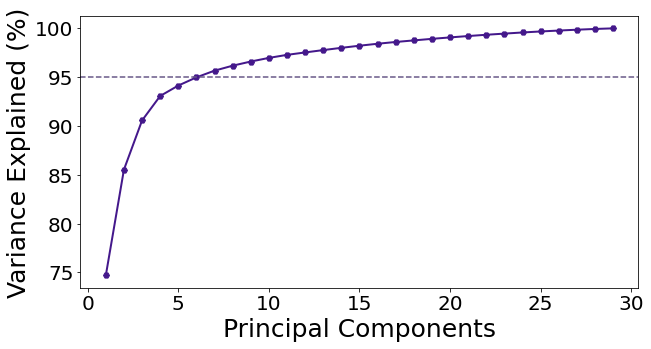

In [13]:
# Let's take a look at the explained variance from the PCA
explained_variance=whole_pca.explained_variance_ratio_
cumulative_variance=np.cumsum(explained_variance)*100
PCs=np.linspace(1,len(cumulative_variance),len(cumulative_variance))
plt.figure(figsize=(10,5))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Principal Components",fontsize=25)
plt.ylabel("Variance Explained (%)",fontsize=25)
plt.plot(PCs,cumulative_variance,marker='H',linewidth=2,color='#44188B')
plt.axhline(y=95,color='#665687',linestyle='--')
plt.savefig(r"C:\Users\paula\Documents\Grad School\Courses\ENSF619\PCAvar.png", dpi=500, bbox_inches="tight")

In [14]:
# Only 6 components are needed to explain 95% of the variance in our training data. Now we can fit a support vector classifier
# (SVC) to our training data and test it on our test data. Note that we are not doing any hyperparameter optimization here so a 
# validation set is not needed. It takes about 10 minutes to run this block of code.

svm = SVC(kernel='linear', random_state=0)
svm.fit(train_PCA, train_labels)

y_pred_test=svm.predict(test_PCA)

In [15]:
#Now we'll construct a dataframe that summarizes our results. First we want to connect the predictions, true labels, and image
# names in the test set

SVC_results_list=[]
for i in range(0,len(y_pred_test)):
    result=[y_pred_test[i],test_labels[i],test_image_name[i]]
    SVC_results_list.append(result)

# Convert into a dataframe
svc_results_df=pd.DataFrame(SVC_results_list, columns=['predicted label', 'true label', 'image'])

# The metric we're going to use to compare our two groups (5xFAD vs WT) is the percentage of kernels classified as diseased or
# "sick" (class 1) in each image. The line below calculates that metric for each image in the test set
percent_sick = (svc_results_df['predicted label'] == 1).groupby(svc_results_df['image']).mean() * 100

#Convert to a dataframe
percentage_df = pd.DataFrame({'image': percent_sick.index, 'percent sick': percent_sick.values})

#Create dataframe that has only images (not kernels) and true labels
images_and_true_labels = svc_results_df.drop('predicted label',axis=1)
images_and_true_labels=images_and_true_labels.drop_duplicates()

#Combine the two dataframes so we have the image name, percentage sick, and true values together
merged_df_SVC = pd.merge(percentage_df, images_and_true_labels, on='image')

In [125]:
print(merged_df_SVC)

                                  image  percent sick  true label
0    230307_5xFAD1 ML R10(bsub)(JP2Q90)     69.777778           1
1    230307_5xFAD1 ML R13(bsub)(JP2Q90)     99.555556           1
2    230307_5xFAD1 ML R14(bsub)(JP2Q90)     94.505495           1
3    230307_5xFAD1 ML R15(bsub)(JP2Q90)     97.457627           1
4    230307_5xFAD1 ML R18(bsub)(JP2Q90)     89.333333           1
..                                  ...           ...         ...
195     230315_WT5 ML R28(bsub)(JP2Q90)      6.666667           0
196     230315_WT5 ML R29(bsub)(JP2Q90)     10.666667           0
197     230315_WT5 ML R30(bsub)(JP2Q90)     37.435897           0
198      230315_WT5 ML R8(bsub)(JP2Q90)     55.555556           0
199      230315_WT5 ML R9(bsub)(JP2Q90)     58.333333           0

[200 rows x 3 columns]


In [132]:
#Calculate some statistics
percents_5xFAD = merged_df_SVC.loc[merged_df_SVC['true label'] == 1, 'percent sick'].tolist()
percents_WT = merged_df_SVC.loc[merged_df_SVC['true label'] == 0, 'percent sick'].tolist()

mean_5xFAD=np.mean(percents_5xFAD)
mean_WT=np.mean(percents_WT)

ttest, pval = ttest_ind(percents_5xFAD, percents_WT, alternative="greater")

print('Mean % of 5xFAD labelled kernels in images with true label 5xFAD:',mean_5xFAD,'+/-',np.std(percents_5xFAD))
print('Mode % of 5xFAD labelled kernels in images with true label 5xFAD:',statistics.mode(percents_5xFAD))
print('Mean % of 5xFAD labelled kernels in images with true label WT:',mean_WT,'+/-',np.std(percents_WT))
print('Mode % of 5xFAD labelled kernels in images with true label WT:',statistics.mode(percents_WT))
print('p-value for test percents_5xFAD>percents_WT:',pval)

Mean % of 5xFAD labelled kernels in images with true label 5xFAD: 78.8024689410113 +/- 21.137051504513806
Mode % of 5xFAD labelled kernels in images with true label 5xFAD: 100.0
Mean % of 5xFAD labelled kernels in images with true label WT: 32.312343550407945 +/- 37.61394446081158
Mode % of 5xFAD labelled kernels in images with true label WT: 0.0
p-value for test percents_5xFAD>percents_WT: 6.867014130878825e-23


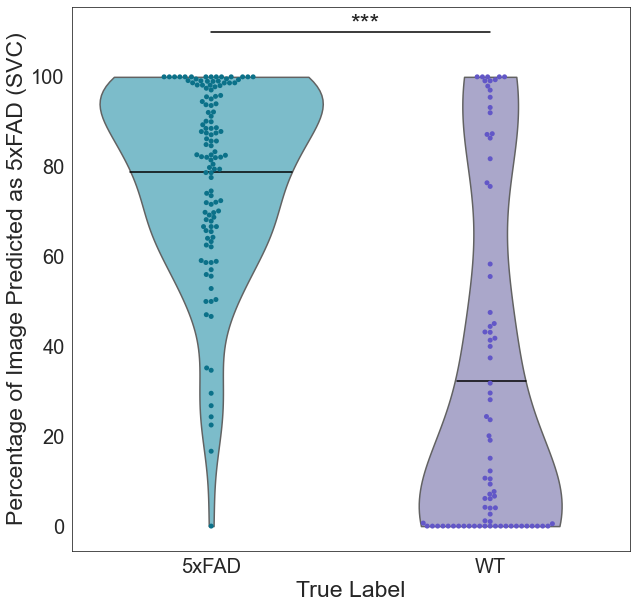

In [17]:
# Create a plot of the results
sns.set_style("white")
my_box_colours = {0: "#9C95DC", 1: "#55D5F1"}
my_plot_colours = {0:'#6257C7', 1:'#0B7189'}
fig, ax = plt.subplots(figsize=(10, 10))
plot=sns.swarmplot(x='true label',y='percent sick',data=merged_df_SVC,size=5,dodge=False,ax=ax,palette=my_plot_colours,order=[1,0])
plot=sns.violinplot(x='true label', y='percent sick', data=merged_df_SVC,cut=0,ax=ax,inner=None,palette=my_box_colours,saturation=0.5,order=[1,0])
plot.set_xticklabels(['5xFAD','WT'],fontsize=20)
plot.tick_params(axis='both', which='major', labelsize=20)
plot.set_xlabel('True Label',fontsize=23)
plot.set_ylabel("Percentage of Image Predicted as 5xFAD (SVC)",fontsize=23)
plot=plt.axhline(y=mean_WT,xmin=0.69,xmax=0.815,color='#000000',linestyle='-')
plot=plt.axhline(y=mean_5xFAD,xmin=0.105,xmax=0.395,color='#000000',linestyle='-')
plot=plt.axhline(y=110,xmin=0.25,xmax=0.75,color='#000000')
plot=plt.text(x=0.5,y=110,s='***',fontsize=25)
plt.savefig(r"C:\Users\paula\Documents\Grad School\Courses\ENSF619\SVCGrouped.png", dpi=500, bbox_inches="tight")

In [18]:
#Now we want to do a per mouse analysis of our results. We're going to display the whole dataframe so that we can see which
# indices correspond to each mouse
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(merged_df_SVC)

                                  image  percent sick  true label
0    230307_5xFAD1 ML R10(bsub)(JP2Q90)        69.778           1
1    230307_5xFAD1 ML R13(bsub)(JP2Q90)        99.556           1
2    230307_5xFAD1 ML R14(bsub)(JP2Q90)        94.505           1
3    230307_5xFAD1 ML R15(bsub)(JP2Q90)        97.458           1
4    230307_5xFAD1 ML R18(bsub)(JP2Q90)        89.333           1
5    230307_5xFAD1 ML R20(bsub)(JP2Q90)        97.778           1
6    230307_5xFAD1 ML R28(bsub)(JP2Q90)       100.000           1
7    230307_5xFAD1 ML R29(bsub)(JP2Q90)        99.065           1
8     230307_5xFAD1 ML R3(bsub)(JP2Q90)       100.000           1
9     230307_5xFAD1 ML R7(bsub)(JP2Q90)        66.667           1
10    230307_5xFAD2 ML R1(bsub)(JP2Q90)        87.500           1
11   230307_5xFAD2 ML R11(bsub)(JP2Q90)       100.000           1
12   230307_5xFAD2 ML R12(bsub)(JP2Q90)        98.643           1
13   230307_5xFAD2 ML R19(bsub)(JP2Q90)        98.182           1
14    2303

In [19]:
#Make a big dataframe that lists only the mouse name and percentage classified as 5xFAD. Sorry this is probably the most ugly
# code you've ever seen, it works and now I'm afraid to touch it

percentages_5xFAD1 =merged_df_SVC.iloc[0:10]["percent sick"].values.tolist()
list_5xFAD1 = [['5xFAD1' for _ in range(len(percentages_5xFAD1))],percentages_5xFAD1]
permouse_df = pd.DataFrame (list_5xFAD1).transpose()
permouse_df.columns = ['Mouse_Name', 'Percent Sick']

percentages_5xFAD2 =merged_df_SVC.iloc[10:25]["percent sick"].values.tolist()
list_5xFAD2 = [['5xFAD2' for _ in range(len(percentages_5xFAD2))],percentages_5xFAD2]
permouse_df=permouse_df.append(pd.DataFrame(list_5xFAD2).transpose().rename(columns={0: "Mouse_Name", 1: "Percent Sick"}),ignore_index=True)

percentages_5xFAD3 =merged_df_SVC.iloc[25:41]["percent sick"].values.tolist()
list_5xFAD3 = [['5xFAD3' for _ in range(len(percentages_5xFAD3))],percentages_5xFAD3]
permouse_df=permouse_df.append(pd.DataFrame(list_5xFAD3).transpose().rename(columns={0: "Mouse_Name", 1: "Percent Sick"}),ignore_index=True)

percentages_5xFAD4 =merged_df_SVC.iloc[41:57]["percent sick"].values.tolist()
list_5xFAD4 = [['5xFAD4' for _ in range(len(percentages_5xFAD4))],percentages_5xFAD4]
permouse_df=permouse_df.append(pd.DataFrame(list_5xFAD4).transpose().rename(columns={0: "Mouse_Name", 1: "Percent Sick"}),ignore_index=True)

percentages_5xFAD5 =merged_df_SVC.iloc[57:73]["percent sick"].values.tolist()
list_5xFAD5 = [['5xFAD5' for _ in range(len(percentages_5xFAD5))],percentages_5xFAD5]
permouse_df=permouse_df.append(pd.DataFrame(list_5xFAD5).transpose().rename(columns={0: "Mouse_Name", 1: "Percent Sick"}),ignore_index=True)

percentages_5xFAD6 =merged_df_SVC.iloc[73:93]["percent sick"].values.tolist()
list_5xFAD6 = [['5xFAD6' for _ in range(len(percentages_5xFAD6))],percentages_5xFAD6]
permouse_df=permouse_df.append(pd.DataFrame(list_5xFAD6).transpose().rename(columns={0: "Mouse_Name", 1: "Percent Sick"}),ignore_index=True)

percentages_5xFAD7 =merged_df_SVC.iloc[93:110]["percent sick"].values.tolist()
list_5xFAD7 = [['5xFAD7' for _ in range(len(percentages_5xFAD7))],percentages_5xFAD7]
permouse_df=permouse_df.append(pd.DataFrame(list_5xFAD7).transpose().rename(columns={0: "Mouse_Name", 1: "Percent Sick"}),ignore_index=True)

percentages_5xFAD8 =merged_df_SVC.iloc[110:121]["percent sick"].values.tolist()
list_5xFAD8 = [['5xFAD8' for _ in range(len(percentages_5xFAD8))],percentages_5xFAD8]
permouse_df=permouse_df.append(pd.DataFrame(list_5xFAD8).transpose().rename(columns={0: "Mouse_Name", 1: "Percent Sick"}),ignore_index=True)

percentages_WT1 =merged_df_SVC.iloc[121:139]["percent sick"].values.tolist()
list_WT1 = [['WT1' for _ in range(len(percentages_WT1))],percentages_WT1]
permouse_df=permouse_df.append(pd.DataFrame(list_WT1).transpose().rename(columns={0: "Mouse_Name", 1: "Percent Sick"}),ignore_index=True)

percentages_WT2 =merged_df_SVC.iloc[139:144]["percent sick"].values.tolist()
list_WT2 = [['WT2' for _ in range(len(percentages_WT2))],percentages_WT2]
permouse_df=permouse_df.append(pd.DataFrame(list_WT2).transpose().rename(columns={0: "Mouse_Name", 1: "Percent Sick"}),ignore_index=True)

percentages_WT3 =merged_df_SVC.iloc[144:162]["percent sick"].values.tolist()
list_WT3 = [['WT3' for _ in range(len(percentages_WT3))],percentages_WT3]
permouse_df=permouse_df.append(pd.DataFrame(list_WT3).transpose().rename(columns={0: "Mouse_Name", 1: "Percent Sick"}),ignore_index=True)

percentages_WT4 =merged_df_SVC.iloc[162:186]["percent sick"].values.tolist()
list_WT4 = [['WT4' for _ in range(len(percentages_WT4))],percentages_WT4]
permouse_df=permouse_df.append(pd.DataFrame(list_WT4).transpose().rename(columns={0: "Mouse_Name", 1: "Percent Sick"}),ignore_index=True)

percentages_WT5 =merged_df_SVC.iloc[186:199]["percent sick"].values.tolist()
list_WT5 = [['WT5' for _ in range(len(percentages_WT5))],percentages_WT5]
permouse_df=permouse_df.append(pd.DataFrame(list_WT5).transpose().rename(columns={0: "Mouse_Name", 1: "Percent Sick"}),ignore_index=True)

In [20]:
#Calcualte some statistics in case we want to examine these later

data = np.concatenate([percentages_5xFAD1,percentages_5xFAD2,percentages_5xFAD3,percentages_5xFAD4,percentages_5xFAD5,percentages_5xFAD6,percentages_5xFAD7,percentages_5xFAD8,percentages_WT1,percentages_WT2,percentages_WT3,percentages_WT4,percentages_WT5])

# Create a list of labels for the data
labels = ['5xFAD1'] * len(percentages_5xFAD1) + ['5xFAD2'] * len(percentages_5xFAD2) + ['5xFAD3'] * len(percentages_5xFAD3)+ ['5xFAD4'] * len(percentages_5xFAD4)+ ['5xFAD5'] * len(percentages_5xFAD5)+ ['5xFAD6'] * len(percentages_5xFAD6)+ ['5xFAD7'] * len(percentages_5xFAD7)+ ['5xFAD8'] * len(percentages_5xFAD8)+ ['WT1'] * len(percentages_WT1)+ ['WT2'] * len(percentages_WT2)+ ['WT3'] * len(percentages_WT3)+ ['WT4'] * len(percentages_WT4)+ ['WT5'] * len(percentages_WT5)

# Perform one-way ANOVA to test for significant differences between the groups
f, p = f_oneway(percentages_5xFAD1,percentages_5xFAD2,percentages_5xFAD3,percentages_5xFAD4,percentages_5xFAD5,percentages_5xFAD6,percentages_5xFAD7,percentages_5xFAD8,percentages_WT1,percentages_WT2,percentages_WT3,percentages_WT4,percentages_WT5)

# Perform Tukey's HSD test to determine which groups are significantly different from each other
tukey_results = mc.pairwise_tukeyhsd(data, labels, alpha=0.05)

# Print the results of the tests
print('One-way ANOVA results:')
print('F-value:', f)
print('p-value:', p)
print('\nTukey HSD test results:')
print(tukey_results)


One-way ANOVA results:
F-value: 79.58214755305556
p-value: 1.540558040543488e-66

Tukey HSD test results:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
5xFAD1 5xFAD2   4.7549    0.9    -16.29  25.7997  False
5xFAD1 5xFAD3  -8.5076    0.9  -29.2877  12.2725  False
5xFAD1 5xFAD4 -20.3099 0.0626  -41.0901   0.4702  False
5xFAD1 5xFAD5   6.0217    0.9  -14.7584  26.8019  False
5xFAD1 5xFAD6 -26.4411 0.0011   -46.406  -6.4762   True
5xFAD1 5xFAD7 -21.7325 0.0275  -42.2762  -1.1888   True
5xFAD1 5xFAD8 -30.3915  0.001   -52.915  -7.8681   True
5xFAD1    WT1 -69.4305  0.001  -89.7617 -49.0992   True
5xFAD1    WT2 -91.1773  0.001 -119.4119 -62.9426   True
5xFAD1    WT3   2.6013    0.9    -17.73  22.9326  False
5xFAD1    WT4 -90.7282  0.001 -110.1306 -71.3258   True
5xFAD1    WT5 -61.5123  0.001  -83.1951 -39.8296   True
5xFAD2 5xFAD3 -13.2625 0.4507  -31.7891   5.2642  Fals

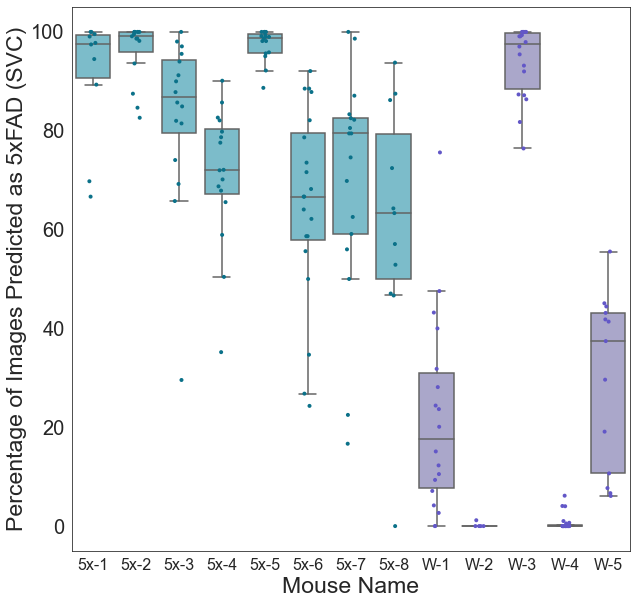

In [21]:
#Create a plot of the results for each mouse

sns.set_style("white")
WT_list=['WT1','WT2','WT3','WT4','WT5']
my_box_colours = {Mouse_Name: "#9C95DC" if Mouse_Name in WT_list else "#55D5F1" for Mouse_Name in permouse_df.Mouse_Name.unique()}
my_plot_colours = {Mouse_Name: "#6257C7" if Mouse_Name in WT_list else "#0B7189" for Mouse_Name in permouse_df.Mouse_Name.unique()}
fig, ax = plt.subplots(figsize=(10, 10))
plot=sns.stripplot(x='Mouse_Name',y='Percent Sick',data=permouse_df,size=4,ax=ax,palette=my_plot_colours)
plot=sns.boxplot(x='Mouse_Name', y='Percent Sick', data=permouse_df,saturation=0.5,palette=my_box_colours,ax=ax,fliersize=0)
plot.set_xticklabels(['5x-1','5x-2','5x-3','5x-4','5x-5','5x-6','5x-7','5x-8','W-1','W-2','W-3','W-4','W-5'],fontsize=16)
plot.tick_params(axis='y', which='major', labelsize=20)
plot.set_xlabel('Mouse Name',fontsize=23)
plot.set_ylabel("Percentage of Images Predicted as 5xFAD (SVC)",fontsize=23)
plt.savefig(r"C:\Users\paula\Documents\Grad School\Courses\ENSF619\SVCpermouse.png", dpi=500, bbox_inches="tight")

In [80]:
# Now we have our results from the SVC after PCA. Let's analyze the PCA data using a neural network now and see if there are 
# any changes.

#Get the data we want to use in the neural network
train_NN=PCADataset(images=train_PCA,labels=train_labels,image_names=train_image_name)
valid_NN=PCADataset(images=valid_PCA,labels=valid_labels,image_names=valid_image_name)
test_NN=PCADataset(images=test_PCA,labels=test_labels,image_names=test_image_name)

#Use the DataLoader function to create batches of data
train_NN_loader=DataLoader(train_NN,batch_size=4,shuffle=True)
valid_NN_loader=DataLoader(valid_NN,batch_size=4,shuffle=True)
test_NN_loader=DataLoader(test_NN,batch_size=1,shuffle=True)

In [81]:
# Use a GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model=DenseModel(nodes=20,PCA_components=components_for_95)

#Learning rate for neural network
lr=0.001
#Binary cross entropy loss for a two class problem
criterion=nn.BCELoss() 
optimizer=torch.optim.SGD(model.parameters(),lr=lr,momentum=0.95)

In [82]:
#Train the neural network
model_save_name = 'DenseNN.pth'
PATH = "C:/Users/paula/Documents/Grad School/Courses/ENSF619/ENSF 619 Final Project/{model_save_name}"
model.to(device)
trainloss_list=[]
valloss_list=[]

best_loss = 1e+20
nepochs=50
for epoch in range(nepochs):  # loop over the dataset multiple times
    # Training Loop
    train_loss = 0.0
    for i, data in enumerate(train_NN_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs=inputs.to(torch.float32)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        labels=labels.long()
        #Convert labels to one hot encoding in order to match the size of the outputs
        labels=nn.functional.one_hot(labels,num_classes=2)
        labels=labels.float()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f'{epoch + 1},  train loss: {train_loss / i:.3f},', end = ' ')
    trainloss_list.append(train_loss/i)

    val_loss = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data in enumerate(valid_NN_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs=inputs.to(torch.float32)
            outputs = model(inputs)
            labels=labels.long()
            labels=nn.functional.one_hot(labels,num_classes=2)
            labels=labels.float()
            loss = criterion(outputs, labels)

            val_loss += loss.item()


        print(f'Validation Loss: {val_loss / i:.3f}')
        valloss_list.append(val_loss/i)
        
        # Save best model
        if val_loss < best_loss:
            best_loss=val_loss
            print("Saving Model")
            torch.save(model.state_dict(), PATH)
    if early_stopper.early_stop(val_loss):
                nepochs = epoch +1 
                print("Early Stopping")
                break

1,  train loss: 0.567, Validation Loss: 0.511
Saving Model
2,  train loss: 0.528, Validation Loss: 0.504
Saving Model
3,  train loss: 0.518, Validation Loss: 0.495
Saving Model
4,  train loss: 0.506, Validation Loss: 0.487
Saving Model
5,  train loss: 0.498, Validation Loss: 0.488
6,  train loss: 0.493, Validation Loss: 0.478
Saving Model
7,  train loss: 0.490, Validation Loss: 0.463
Saving Model
8,  train loss: 0.488, Validation Loss: 0.467
9,  train loss: 0.485, Validation Loss: 0.457
Saving Model
10,  train loss: 0.484, Validation Loss: 0.456
Saving Model
11,  train loss: 0.482, Validation Loss: 0.473
12,  train loss: 0.480, Validation Loss: 0.453
Saving Model
13,  train loss: 0.479, Validation Loss: 0.454
14,  train loss: 0.478, Validation Loss: 0.480
15,  train loss: 0.477, Validation Loss: 0.477
16,  train loss: 0.476, Validation Loss: 0.449
Saving Model
17,  train loss: 0.475, Validation Loss: 0.462
18,  train loss: 0.474, Validation Loss: 0.445
Saving Model
19,  train loss: 0.4

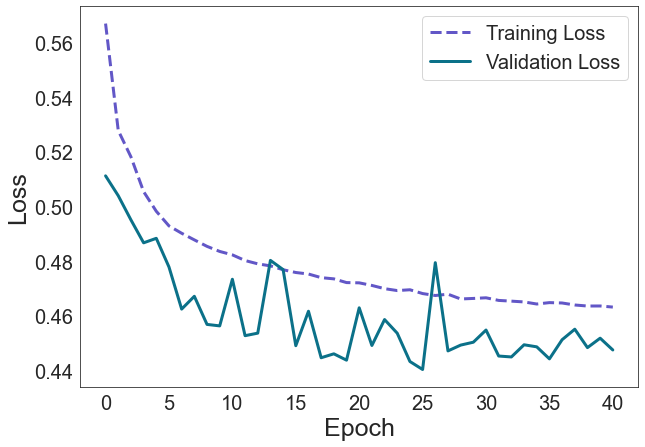

In [106]:
plt.figure(figsize=(10,7))
plt.plot(range(0,epoch+1),trainloss_list,label='Training Loss',color='#6257C7',linewidth=3,linestyle='--')
plt.plot(range(0,epoch+1),valloss_list,label='Validation Loss',color='#0B7189',linewidth=3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.xlabel('Epoch',fontsize=25)
plt.ylabel('Loss',fontsize=25)
plt.savefig(r"C:\Users\paula\Documents\Grad School\Courses\ENSF619\losscurve.png", dpi=500, bbox_inches="tight")

In [84]:
#Test the neural network
model.to(device)
model.load_state_dict(torch.load(PATH))
preds=[]
testlabels=[]
names=[]
# again no gradients needed
with torch.no_grad():
    for data in test_NN_loader:
        images, labels, name = data[0].to(device), data[1].to(device), data[2]
        images=images.to(torch.float32)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        preds.append(int(predictions))
        testlabels.append(int(labels))
        names.append(name)

In [85]:
#As in the SVC results, we're going to create a dataframe that summarizes all of our results and reports the percentage of
# kernels that were classified as 5xFAD in each image
NN_results_list=[]
for i in range(0,len(preds)):
    result=[preds[i],testlabels[i],names[i]]
    NN_results_list.append(result)

NN_results_df=pd.DataFrame(NN_results_list, columns=['predicted label', 'true label', 'image'])
percent_sick = (NN_results_df['predicted label'] == 1).groupby(NN_results_df['image']).mean() * 100
percentage_df = pd.DataFrame({'image': percent_sick.index, 'percent sick': percent_sick.values})

images_and_true_labels = NN_results_df.drop('predicted label',axis=1)
images_and_true_labels=images_and_true_labels.drop_duplicates()
merged_df_NN = pd.merge(percentage_df, images_and_true_labels, on='image')

In [133]:
#Calculate some statistics
percents_5xFAD = merged_df_NN.loc[merged_df_SVC['true label'] == 1, 'percent sick'].tolist()
percents_WT = merged_df_NN.loc[merged_df_SVC['true label'] == 0, 'percent sick'].tolist()

mean_5xFAD=np.mean(percents_5xFAD)
mean_WT=np.mean(percents_WT)

ttest, pval = ttest_ind(percents_5xFAD, percents_WT, alternative="greater")

print('p-value for test percents_5xFAD>percents_WT:',pval)
print('Mean % of 5xFAD labelled kernels in images with true label 5xFAD:',mean_5xFAD,'+/-',np.std(percents_5xFAD))
print('Mode % of 5xFAD labelled kernels in images with true label 5xFAD:',statistics.mode(percents_5xFAD))
print('Mean % of 5xFAD labelled kernels in images with true label WT:',mean_WT,'+/-',np.std(percents_WT))
print('Mode % of 5xFAD labelled kernels in images with true label WT:',statistics.mode(percents_WT))
print('p-value for test percents_5xFAD>percents_WT:',pval)

p-value for test percents_5xFAD>percents_WT: 8.143427439077517e-27
Mean % of 5xFAD labelled kernels in images with true label 5xFAD: 76.77156080187241 +/- 18.80087895884583
Mode % of 5xFAD labelled kernels in images with true label 5xFAD: 100.0
Mean % of 5xFAD labelled kernels in images with true label WT: 30.282047784936257 +/- 33.78661185619617
Mode % of 5xFAD labelled kernels in images with true label WT: 0.0
p-value for test percents_5xFAD>percents_WT: 8.143427439077517e-27


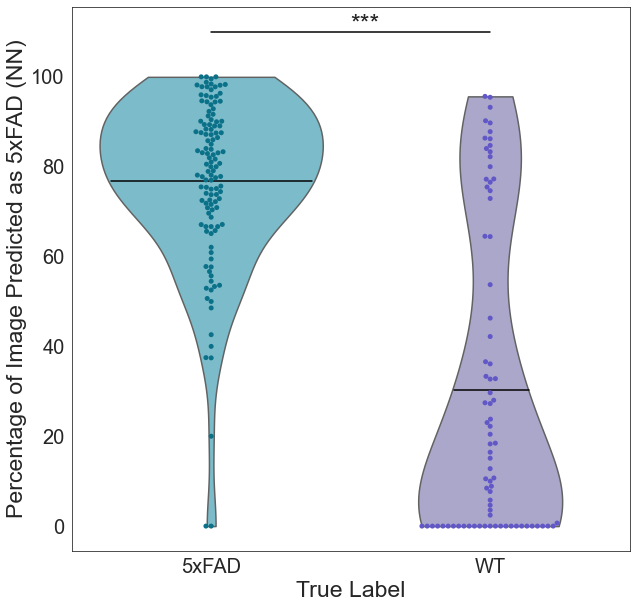

In [120]:
# Create a plot of the results
sns.set_style("white")
my_box_colours = {0: "#9C95DC", 1: "#55D5F1"}
my_plot_colours = {0:'#6257C7', 1:'#0B7189'}
fig, ax = plt.subplots(figsize=(10, 10))
plot=sns.swarmplot(x='true label',y='percent sick',data=merged_df_NN,size=5,dodge=False,ax=ax,palette=my_plot_colours,order=[1,0])
plot=sns.violinplot(x='true label', y='percent sick', data=merged_df_NN,cut=0,ax=ax,inner=None,palette=my_box_colours,saturation=0.5,order=[1,0])
plot.set_xticklabels(['5xFAD','WT'],fontsize=20)
plot.tick_params(axis='both', which='major', labelsize=20)
plot.set_xlabel('True Label',fontsize=23)
plot.set_ylabel("Percentage of Image Predicted as 5xFAD (NN)",fontsize=23)
plot=plt.axhline(y=mean_WT,xmin=0.685,xmax=0.82,color='#000000',linestyle='-')
plot=plt.axhline(y=mean_5xFAD,xmin=0.07,xmax=0.43,color='#000000',linestyle='-')
plot=plt.text(x=0.5,y=110,s='***',fontsize=25)
plot=plt.axhline(y=110,xmin=0.25,xmax=0.75,color='#000000')
plt.savefig(r"C:\Users\paula\Documents\Grad School\Courses\ENSF619\NNgrouped.png", dpi=500, bbox_inches="tight")

In [88]:
# Since we are testing on the same data as was used in the SVC, the indices we want to check are the same. No need to print
# out the whole dataframe to find what we're looking for in the per mouse comparison.

percentages_5xFAD1 =merged_df_NN.iloc[0:10]["percent sick"].values.tolist()
list_5xFAD1 = [['5xFAD1' for _ in range(len(percentages_5xFAD1))],percentages_5xFAD1]
permouse_df = pd.DataFrame (list_5xFAD1).transpose()
permouse_df.columns = ['Mouse_Name', 'Percent Sick']

percentages_5xFAD2 =merged_df_NN.iloc[10:25]["percent sick"].values.tolist()
list_5xFAD2 = [['5xFAD2' for _ in range(len(percentages_5xFAD2))],percentages_5xFAD2]
permouse_df=permouse_df.append(pd.DataFrame(list_5xFAD2).transpose().rename(columns={0: "Mouse_Name", 1: "Percent Sick"}),ignore_index=True)

percentages_5xFAD3 =merged_df_NN.iloc[25:41]["percent sick"].values.tolist()
list_5xFAD3 = [['5xFAD3' for _ in range(len(percentages_5xFAD3))],percentages_5xFAD3]
permouse_df=permouse_df.append(pd.DataFrame(list_5xFAD3).transpose().rename(columns={0: "Mouse_Name", 1: "Percent Sick"}),ignore_index=True)

percentages_5xFAD4 =merged_df_NN.iloc[41:57]["percent sick"].values.tolist()
list_5xFAD4 = [['5xFAD4' for _ in range(len(percentages_5xFAD4))],percentages_5xFAD4]
permouse_df=permouse_df.append(pd.DataFrame(list_5xFAD4).transpose().rename(columns={0: "Mouse_Name", 1: "Percent Sick"}),ignore_index=True)

percentages_5xFAD5 =merged_df_NN.iloc[57:73]["percent sick"].values.tolist()
list_5xFAD5 = [['5xFAD5' for _ in range(len(percentages_5xFAD5))],percentages_5xFAD5]
permouse_df=permouse_df.append(pd.DataFrame(list_5xFAD5).transpose().rename(columns={0: "Mouse_Name", 1: "Percent Sick"}),ignore_index=True)

percentages_5xFAD6 =merged_df_NN.iloc[73:93]["percent sick"].values.tolist()
list_5xFAD6 = [['5xFAD6' for _ in range(len(percentages_5xFAD6))],percentages_5xFAD6]
permouse_df=permouse_df.append(pd.DataFrame(list_5xFAD6).transpose().rename(columns={0: "Mouse_Name", 1: "Percent Sick"}),ignore_index=True)

percentages_5xFAD7 =merged_df_NN.iloc[93:110]["percent sick"].values.tolist()
list_5xFAD7 = [['5xFAD7' for _ in range(len(percentages_5xFAD7))],percentages_5xFAD7]
permouse_df=permouse_df.append(pd.DataFrame(list_5xFAD7).transpose().rename(columns={0: "Mouse_Name", 1: "Percent Sick"}),ignore_index=True)

percentages_5xFAD8 =merged_df_NN.iloc[110:121]["percent sick"].values.tolist()
list_5xFAD8 = [['5xFAD8' for _ in range(len(percentages_5xFAD8))],percentages_5xFAD8]
permouse_df=permouse_df.append(pd.DataFrame(list_5xFAD8).transpose().rename(columns={0: "Mouse_Name", 1: "Percent Sick"}),ignore_index=True)

percentages_WT1 =merged_df_NN.iloc[121:139]["percent sick"].values.tolist()
list_WT1 = [['WT1' for _ in range(len(percentages_WT1))],percentages_WT1]
permouse_df=permouse_df.append(pd.DataFrame(list_WT1).transpose().rename(columns={0: "Mouse_Name", 1: "Percent Sick"}),ignore_index=True)

percentages_WT2 =merged_df_NN.iloc[139:144]["percent sick"].values.tolist()
list_WT2 = [['WT2' for _ in range(len(percentages_WT2))],percentages_WT2]
permouse_df=permouse_df.append(pd.DataFrame(list_WT2).transpose().rename(columns={0: "Mouse_Name", 1: "Percent Sick"}),ignore_index=True)

percentages_WT3 =merged_df_NN.iloc[144:162]["percent sick"].values.tolist()
list_WT3 = [['WT3' for _ in range(len(percentages_WT3))],percentages_WT3]
permouse_df=permouse_df.append(pd.DataFrame(list_WT3).transpose().rename(columns={0: "Mouse_Name", 1: "Percent Sick"}),ignore_index=True)

percentages_WT4 =merged_df_NN.iloc[162:186]["percent sick"].values.tolist()
list_WT4 = [['WT4' for _ in range(len(percentages_WT4))],percentages_WT4]
permouse_df=permouse_df.append(pd.DataFrame(list_WT4).transpose().rename(columns={0: "Mouse_Name", 1: "Percent Sick"}),ignore_index=True)

percentages_WT5 =merged_df_NN.iloc[186:199]["percent sick"].values.tolist()
list_WT5 = [['WT5' for _ in range(len(percentages_WT5))],percentages_WT5]
permouse_df=permouse_df.append(pd.DataFrame(list_WT5).transpose().rename(columns={0: "Mouse_Name", 1: "Percent Sick"}),ignore_index=True)

In [89]:
#Calcualte some statistics in case we want to examine these later

data = np.concatenate([percentages_5xFAD1,percentages_5xFAD2,percentages_5xFAD3,percentages_5xFAD4,percentages_5xFAD5,percentages_5xFAD6,percentages_5xFAD7,percentages_5xFAD8,percentages_WT1,percentages_WT2,percentages_WT3,percentages_WT4,percentages_WT5])

# Create a list of labels for the data
labels = ['5xFAD1'] * len(percentages_5xFAD1) + ['5xFAD2'] * len(percentages_5xFAD2) + ['5xFAD3'] * len(percentages_5xFAD3)+ ['5xFAD4'] * len(percentages_5xFAD4)+ ['5xFAD5'] * len(percentages_5xFAD5)+ ['5xFAD6'] * len(percentages_5xFAD6)+ ['5xFAD7'] * len(percentages_5xFAD7)+ ['5xFAD8'] * len(percentages_5xFAD8)+ ['WT1'] * len(percentages_WT1)+ ['WT2'] * len(percentages_WT2)+ ['WT3'] * len(percentages_WT3)+ ['WT4'] * len(percentages_WT4)+ ['WT5'] * len(percentages_WT5)

# Perform one-way ANOVA to test for significant differences between the groups
f, p = f_oneway(percentages_5xFAD1,percentages_5xFAD2,percentages_5xFAD3,percentages_5xFAD4,percentages_5xFAD5,percentages_5xFAD6,percentages_5xFAD7,percentages_5xFAD8,percentages_WT1,percentages_WT2,percentages_WT3,percentages_WT4,percentages_WT5)

# Perform Tukey's HSD test to determine which groups are significantly different from each other
tukey_results = mc.pairwise_tukeyhsd(data, labels, alpha=0.05)

# Print the results of the tests
print('One-way ANOVA results:')
print('F-value:', f)
print('p-value:', p)
print('\nTukey HSD test results:')
print(tukey_results)

One-way ANOVA results:
F-value: 67.73985225987853
p-value: 3.1611531917717476e-61

Tukey HSD test results:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
5xFAD1 5xFAD2   0.9938    0.9  -20.0731  22.0608  False
5xFAD1 5xFAD3 -14.4405 0.4986  -35.2424   6.3615  False
5xFAD1 5xFAD4 -12.5058 0.6927  -33.3078   8.2961  False
5xFAD1 5xFAD5   0.2265    0.9  -20.5755  21.0284  False
5xFAD1 5xFAD6 -15.1856 0.3496  -35.1715   4.8003  False
5xFAD1 5xFAD7 -28.6441  0.001  -49.2094  -8.0788   True
5xFAD1 5xFAD8 -35.7944  0.001  -58.3416 -13.2473   True
5xFAD1    WT1 -61.9389  0.001  -82.2915 -41.5862   True
5xFAD1    WT2 -89.4822  0.001 -117.7465 -61.2179   True
5xFAD1    WT3  -8.4695    0.9  -28.8221  11.8831  False
5xFAD1    WT4  -87.952  0.001 -107.3748 -68.5292   True
5xFAD1    WT5 -65.0819  0.001  -86.7874 -43.3764   True
5xFAD2 5xFAD3 -15.4343 0.2146  -33.9804   3.1118  Fal

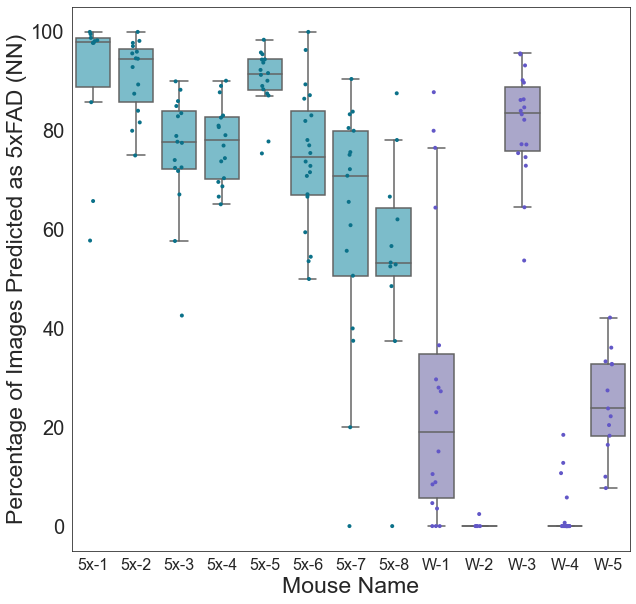

In [90]:
#Create a plot of the results for each mouse

sns.set_style("white")
WT_list=['WT1','WT2','WT3','WT4','WT5']
#{species: "r" if species == "versicolor" else "b" for species in df.species.unique()}
my_box_colours = {Mouse_Name: "#9C95DC" if Mouse_Name in WT_list else "#55D5F1" for Mouse_Name in permouse_df.Mouse_Name.unique()}
my_plot_colours = {Mouse_Name: "#6257C7" if Mouse_Name in WT_list else "#0B7189" for Mouse_Name in permouse_df.Mouse_Name.unique()}
fig, ax = plt.subplots(figsize=(10, 10))
plot=sns.stripplot(x='Mouse_Name',y='Percent Sick',data=permouse_df,size=4,ax=ax,palette=my_plot_colours)
plot=sns.boxplot(x='Mouse_Name', y='Percent Sick', data=permouse_df,saturation=0.5,palette=my_box_colours,ax=ax,fliersize=0)
plot.set_xticklabels(['5x-1','5x-2','5x-3','5x-4','5x-5','5x-6','5x-7','5x-8','W-1','W-2','W-3','W-4','W-5'],fontsize=16)
plot.tick_params(axis='y', which='major', labelsize=20)
plot.set_xlabel('Mouse Name',fontsize=23)
plot.set_ylabel("Percentage of Images Predicted as 5xFAD (NN)",fontsize=23)
plt.savefig(r"C:\Users\paula\Documents\Grad School\Courses\ENSF619\NNpermouse.png", dpi=500, bbox_inches="tight")